<a href="https://colab.research.google.com/github/mangalm96/agreement_reddit_ap/blob/main/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L2-regularized logistic regression for binary or multiclass classification; trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals and prints out the strongest coefficients for each class.

In [1]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/Agreement_Reddit_AP/data/"

In [35]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y


In [51]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)



    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
          
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X

    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model

        # y_pred
        dev_actual = self.devY
        dev_pred = self.log_reg.predict(self.devX)

        return dev_pred,dev_actual

        

    def test(self):
      return self.log_reg.score(self.testX, self.testY)

    def dev(self):
      return self.log_reg.score(self.devX, self.devY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [52]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [53]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [54]:
def remove_stop_df(data):
  # remove stopwords
  filt_combined = []
  for word in nltk.word_tokenize(data):

    if word.lower() not in stopwords.words('english'):
      filt_combined.append(word)

  filtered_ip= " ".join(filt_combined)
  return filtered_ip

In [55]:
# confusion matrix

def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()


def print_confusion_test(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.testX, classifier.testY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

In [56]:
trainingFile = directory + "train.txt" 
devFile = directory + "dev.txt" 
testFile = directory + "test.txt"

In [57]:
import pandas as pd

In [58]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    preds,dev_y = simple_classifier.train()
    # make df of pred 
    pred_test = pd.DataFrame({"actual":dev_y,"preds":preds})

    # print(preds)
    # print(devY)
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))


    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)

    simple_classifier.printWeights()

    return pred_test
    

Dev accuracy for best dev model: 0.750, 95% CIs: [0.690 0.810]

Test accuracy for best dev model: 0.755, 95% CIs: [0.690 0.810]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


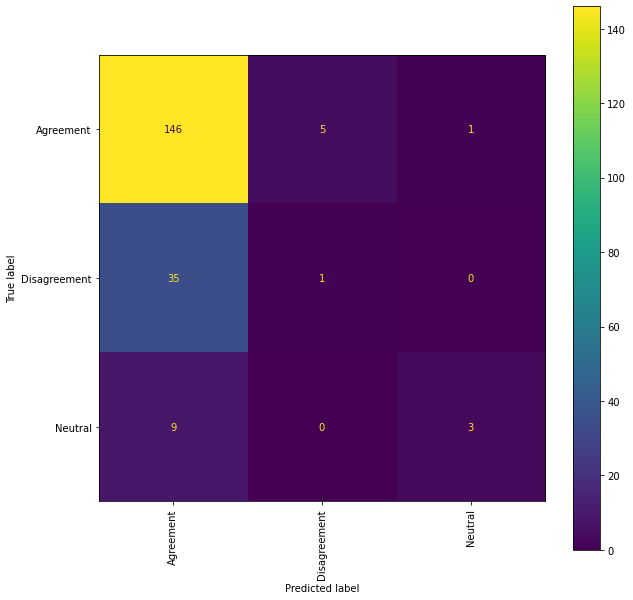

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


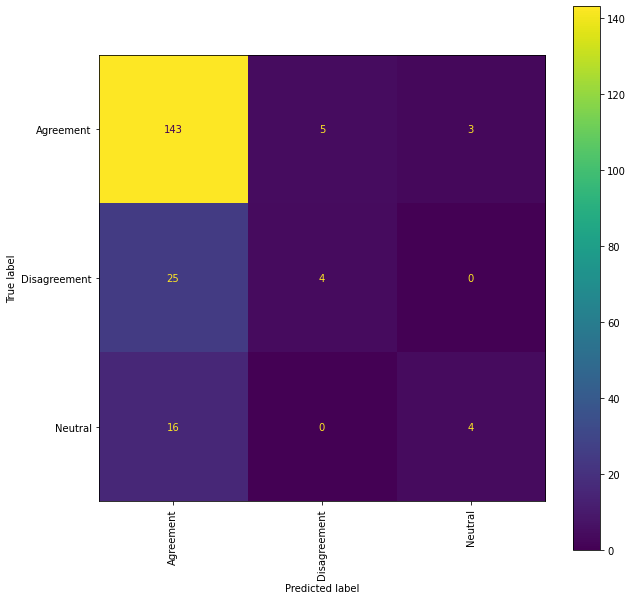

Agreement	0.218	other
Agreement	0.217	that
Agreement	0.198	if
Agreement	0.197	&
Agreement	0.196	%
Agreement	0.175	least
Agreement	0.164	get
Agreement	0.164	before
Agreement	0.159	'd
Agreement	0.158	3

Disagreement	0.321	n't
Disagreement	0.288	i
Disagreement	0.284	?
Disagreement	0.266	actually
Disagreement	0.233	this
Disagreement	0.217	graph
Disagreement	0.206	say
Disagreement	0.187	sure
Disagreement	0.184	simply
Disagreement	0.182	me

Neutral	0.389	and
Neutral	0.293	abstract
Neutral	0.252	we
Neutral	0.221	covid-19
Neutral	0.216	our
Neutral	0.200	by
Neutral	0.178	(
Neutral	0.175	)
Neutral	0.166	.
Neutral	0.162	has



In [59]:
# trainingFile = directory + "train.txt" 
# devFile = directory + "dev.txt" 
# testFile = directory + "test.txt"
    
df = run(trainingFile, devFile, testFile)


In [65]:
devX, devY=load_data(devFile)

In [61]:
df['actual'].value_counts()

Agreement       152
Disagreement     36
Neutral          12
Name: actual, dtype: int64

In [62]:
df['preds'].value_counts()

Agreement       190
Disagreement      6
Neutral           4
Name: preds, dtype: int64

In [68]:
df

,actual,preds
0,Agreement,Agreement
1,Agreement,Agreement
2,Agreement,Agreement
3,Agreement,Agreement
4,Agreement,Agreement
...,...,...
195,Agreement,Agreement
196,Agreement,Agreement
197,Agreement,Agreement
198,Agreement,Agreement


In [69]:
df['text'] = devX

In [70]:
df

,actual,preds,text
0,Agreement,Agreement,"OP, making this vaccine is most likely a waste..."
1,Agreement,Agreement,"Note that the ""fully vaccinated"" group include..."
2,Agreement,Agreement,"thats not clear, IMO mainly cause the mechanis..."
3,Agreement,Agreement,"Also, like with the Norway cluster, they all e..."
4,Agreement,Agreement,Assuming it is true that mRNA vaccines have a ...
...,...,...,...
195,Agreement,Agreement,"Great, now the CDC need to wake up and use the..."
196,Agreement,Agreement,Does anyone know where Novavax is on trials fo...
197,Agreement,Agreement,I can't download the study for some reason but...
198,Agreement,Agreement,"Alright, what's the protection against severe ..."


In [74]:
df.to_csv("iter1.csv")

### After stopword removal

In [13]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))


    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)

    simple_classifier.printWeights()

Dev accuracy for best dev model: 0.740, 95% CIs: [0.679 0.801]

Test accuracy for best dev model: 0.765, 95% CIs: [0.679 0.801]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


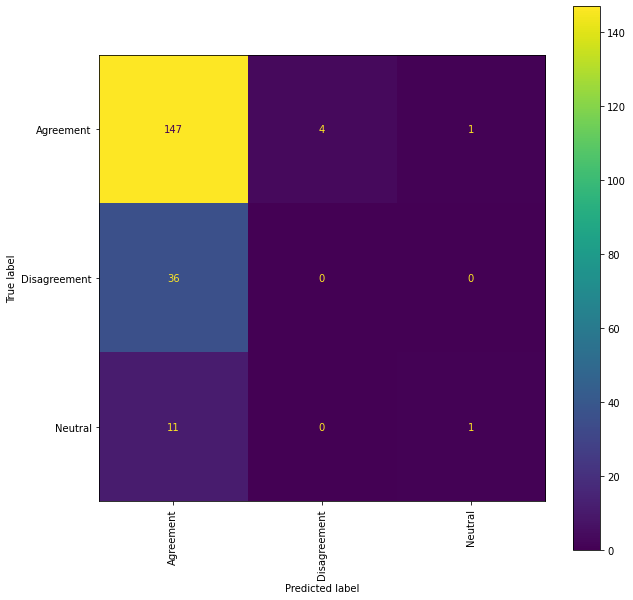

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


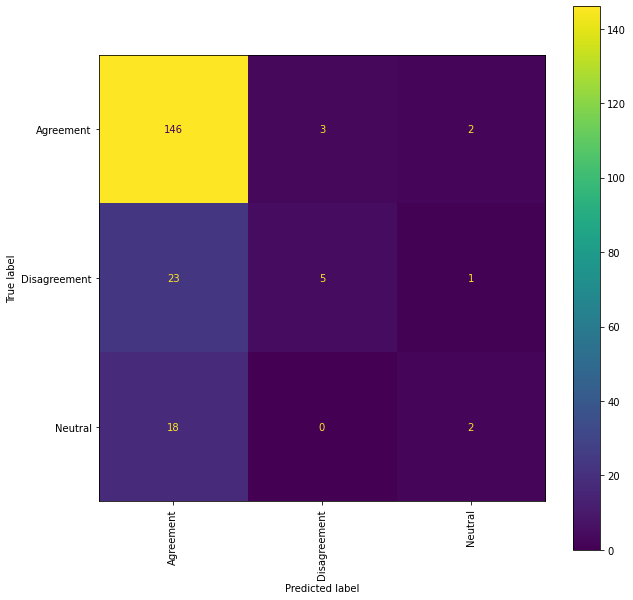

Agreement	0.218	&
Agreement	0.188	%
Agreement	0.179	least
Agreement	0.175	get
Agreement	0.175	?
Agreement	0.175	infections
Agreement	0.154	similar
Agreement	0.152	showed
Agreement	0.151	3
Agreement	0.151	symptoms

Disagreement	0.331	n't
Disagreement	0.310	?
Disagreement	0.292	actually
Disagreement	0.241	going
Disagreement	0.227	say
Disagreement	0.223	sure
Disagreement	0.218	graph
Disagreement	0.191	simply
Disagreement	0.184	spikes
Disagreement	0.184	certain

Neutral	0.342	abstract
Neutral	0.264	covid-19
Neutral	0.197	(
Neutral	0.193	)
Neutral	0.192	pandemic
Neutral	0.186	.
Neutral	0.186	vaccine
Neutral	0.174	sars-cov-2
Neutral	0.159	b
Neutral	0.146	maturation



In [14]:
run(trainingFile, devFile, testFile)


### finding counts

In [15]:
# importing Counter module
from collections import Counter

In [16]:
trainX, trainY=load_data(trainingFile)

devX, devY=load_data(devFile)
testX, testY=load_data(testFile)
print("On Train:",Counter(trainY))
print("On Dev:",Counter(devY))
print("On Test :",Counter(testY))

On Train: Counter({'Agreement': 442, 'Disagreement': 109, 'Neutral': 49})
On Dev: Counter({'Agreement': 152, 'Disagreement': 36, 'Neutral': 12})
On Test : Counter({'Agreement': 151, 'Disagreement': 29, 'Neutral': 20})


### unigram features

In [17]:
agreement_words = ['yes','yeah','absolutely']
diagree_words = ["no","only","garbage","wrong"]
neutral_words = ['should','probably']

In [18]:
def unigram_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()

        if word in agreement_words: 
            feats["contains_agreement_word"] = 1
        if word in diagree_words:
            feats["contains_diagree_word"] = 1
        if word in neutral_words:
            feats["contains_neutral_word"] = 1
        
            
    return feats

In [19]:
def run_feature1(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    simple_classifier = Classifier(unigram_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    print_confusion(simple_classifier)

    
    lower, upper=confidence_intervals(accuracy, len(devY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


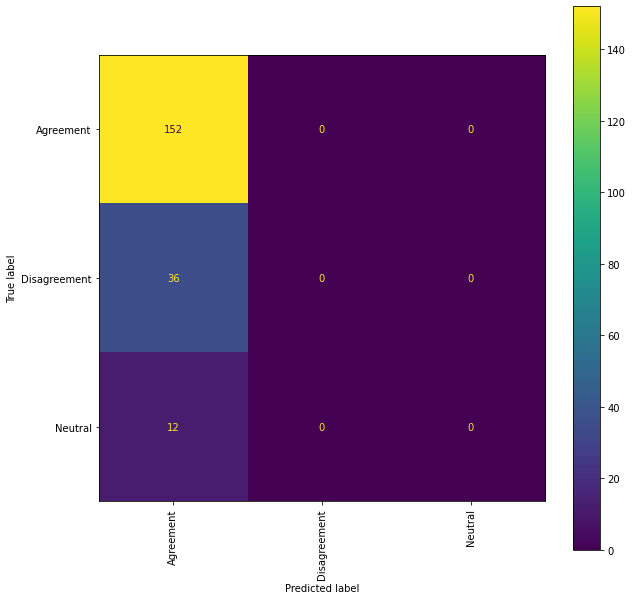

Test accuracy for best dev model: 0.755, 95% CIs: [0.695 0.815]

Agreement	0.168	contains_agreement_word
Agreement	0.075	contains_neutral_word
Agreement	-0.032	contains_diagree_word

Disagreement	0.079	contains_diagree_word
Disagreement	-0.035	contains_neutral_word
Disagreement	-0.090	contains_agreement_word

Neutral	-0.040	contains_neutral_word
Neutral	-0.048	contains_diagree_word
Neutral	-0.078	contains_agreement_word



In [20]:
run_feature1(trainingFile, devFile, testFile)


###Bigram Features

In [21]:
agreement_bigram = ['i agree','great point','good point','great comment']
diagree_bigram = ["so this","is that","i don't", "not exactly"]
# neutral_bigram = ['should','probably']


In [22]:
def bigram_featurize(text):
    feats = {}
    tokens = nltk.word_tokenize(text)

    # lower each token
    token_lower = [token.lower() for token in tokens]

    bigram = list(ngrams(token_lower, 2))

    # separate each bigram with space
    for bi in bigram:
      joined_w = " ".join(bi)
      if joined_w in agreement_bigram:
        print(joined_w)
        feats["contains_agreement_bigram"] = 1
      if joined_w in diagree_bigram:
        print(joined_w)
        feats["contains_diagree_bigram"] = 1
      # if joined_w in neutral_bigram:
      #   feats["contains_neutral_bigram"] = 1
            
    return feats

In [23]:
def run_feature2(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    simple_classifier = Classifier(bigram_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    print_confusion(simple_classifier)

    
    lower, upper=confidence_intervals(accuracy, len(devY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()

good point
great comment
good point
good point


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


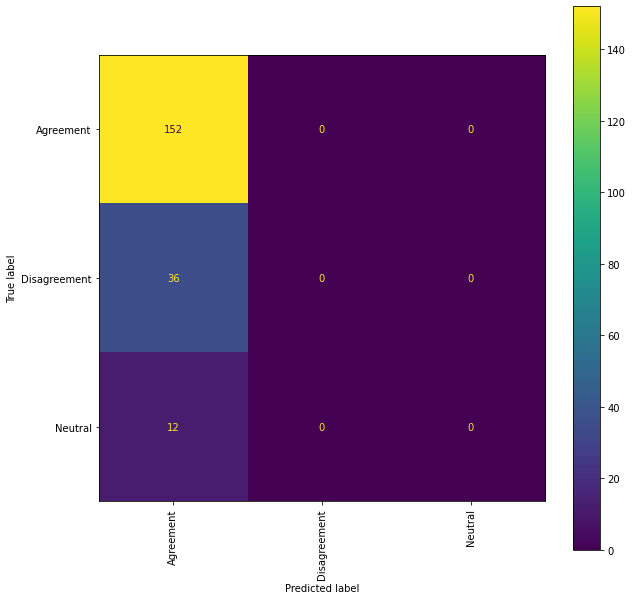

Test accuracy for best dev model: 0.755, 95% CIs: [0.695 0.815]

Agreement	0.050	contains_agreement_bigram

Disagreement	-0.034	contains_agreement_bigram

Neutral	-0.016	contains_agreement_bigram



In [24]:
run_feature2(trainingFile, devFile, testFile)


### Combined features - BOW + Unigram

In [25]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [binary_bow_featurize, unigram_featurize]:
    all_feats.update(feature(text))
  return all_feats

In [26]:
def run_combined(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    simple_classifier = Classifier(combiner_function, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))

    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)

    simple_classifier.printWeights()

Dev accuracy for best dev model: 0.740, 95% CIs: [0.679 0.801]

Test accuracy for best dev model: 0.765, 95% CIs: [0.679 0.801]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


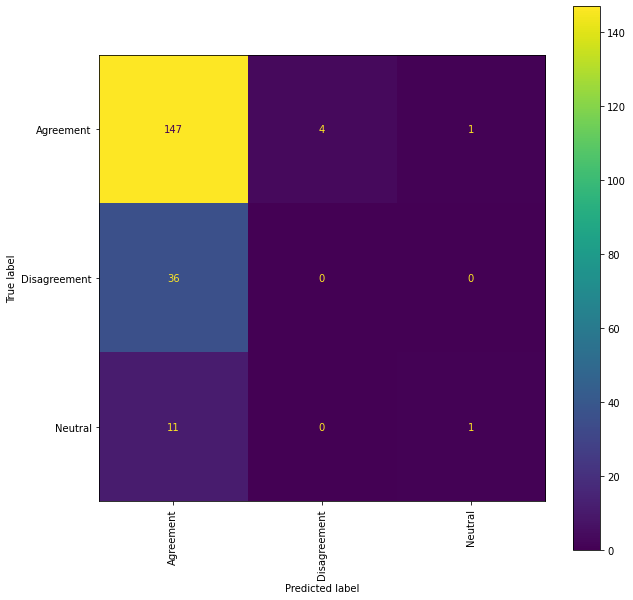

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


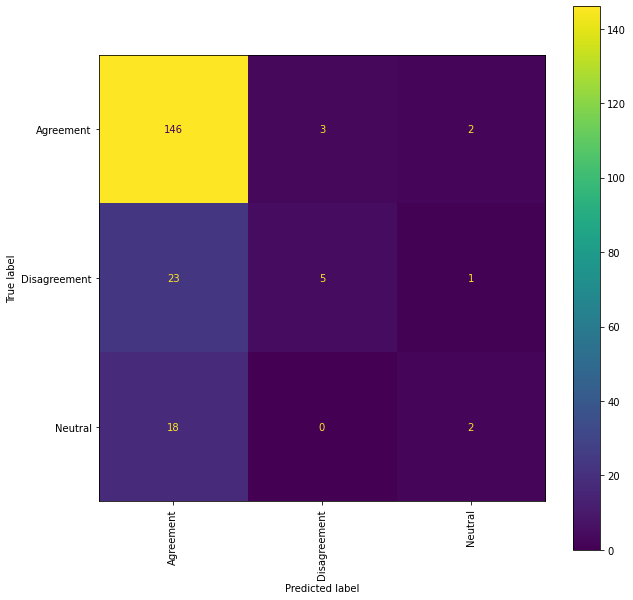

Agreement	0.218	&
Agreement	0.189	%
Agreement	0.179	least
Agreement	0.177	?
Agreement	0.176	infections
Agreement	0.174	get
Agreement	0.153	similar
Agreement	0.153	showed
Agreement	0.152	3
Agreement	0.150	symptoms

Disagreement	0.330	n't
Disagreement	0.309	?
Disagreement	0.292	actually
Disagreement	0.243	going
Disagreement	0.226	say
Disagreement	0.223	sure
Disagreement	0.218	graph
Disagreement	0.191	simply
Disagreement	0.184	spikes
Disagreement	0.184	certain

Neutral	0.342	abstract
Neutral	0.264	covid-19
Neutral	0.197	(
Neutral	0.192	)
Neutral	0.191	pandemic
Neutral	0.186	.
Neutral	0.186	vaccine
Neutral	0.174	sars-cov-2
Neutral	0.159	b
Neutral	0.146	maturation



In [27]:
run_combined(trainingFile, devFile, testFile)


### BOW + Punctuation removal

In [28]:
import string
import re

In [29]:
# list_punct = string.punctuation

In [30]:
def punct_removal(data):
  # remove punctutation
  filt_data = re.sub(r'[^\w\d\s\%\&\?]+', '', data)

  return filt_data

In [31]:
def print_confusion_test(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.testX, classifier.testY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

In [32]:
def run_punct(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    # remove stopwords
    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    # remove punct
    trainX = list(map(punct_removal, trainX))
    devX = list(map(punct_removal, devX))
    testX = list(map(punct_removal, testX))

    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))

    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)
    
    simple_classifier.printWeights()

Dev accuracy for best dev model: 0.745, 95% CIs: [0.685 0.805]

Test accuracy for best dev model: 0.750, 95% CIs: [0.685 0.805]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


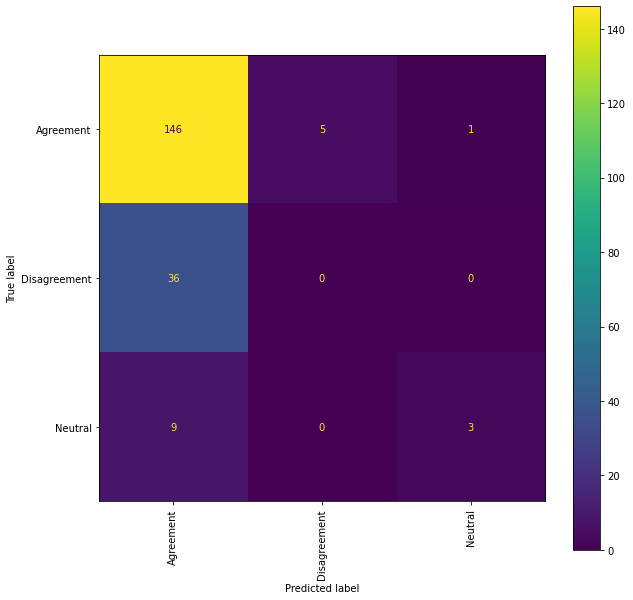

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


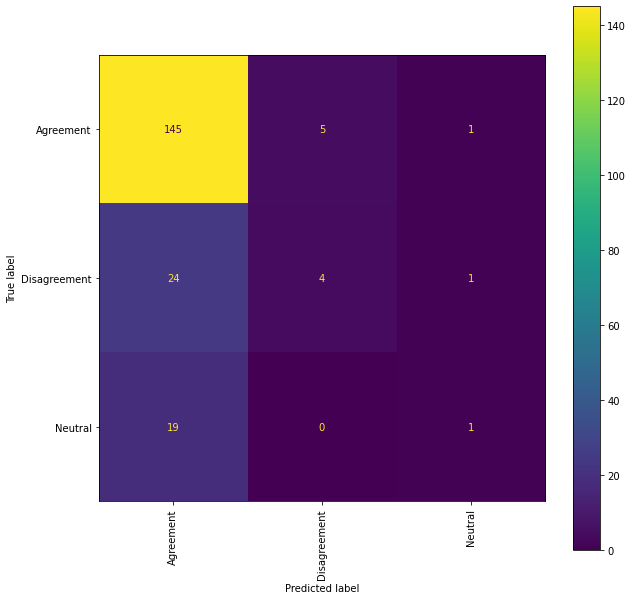

Agreement	0.223	&
Agreement	0.186	?
Agreement	0.184	%
Agreement	0.183	least
Agreement	0.175	infections
Agreement	0.172	get
Agreement	0.159	similar
Agreement	0.158	showed
Agreement	0.157	https
Agreement	0.157	symptoms

Disagreement	0.354	nt
Disagreement	0.340	?
Disagreement	0.292	actually
Disagreement	0.249	going
Disagreement	0.225	say
Disagreement	0.218	sure
Disagreement	0.218	graph
Disagreement	0.195	simply
Disagreement	0.189	certain
Disagreement	0.180	spikes

Neutral	0.400	abstract
Neutral	0.257	covid19
Neutral	0.186	vaccine
Neutral	0.180	pandemic
Neutral	0.174	sarscov2
Neutral	0.160	age
Neutral	0.159	b
Neutral	0.156	maturation
Neutral	0.149	antibodies
Neutral	0.140	roll



In [33]:
run_punct(trainingFile, devFile, testFile)


### Combined (BOW + unigram) with stopword and punct removal

In [34]:
def run_combined_punct(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    # remove punct
    trainX = list(map(punct_removal, trainX))
    devX = list(map(punct_removal, devX))
    testX = list(map(punct_removal, testX))

    simple_classifier = Classifier(combiner_function, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    print_confusion(simple_classifier)

    
    lower, upper=confidence_intervals(accuracy, len(devY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


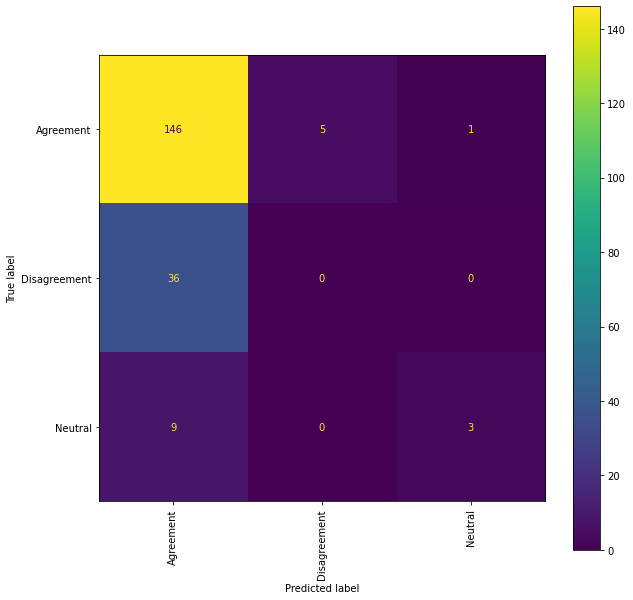

Test accuracy for best dev model: 0.750, 95% CIs: [0.690 0.810]

Agreement	0.223	&
Agreement	0.188	?
Agreement	0.185	%
Agreement	0.183	least
Agreement	0.175	infections
Agreement	0.171	get
Agreement	0.159	similar
Agreement	0.159	showed
Agreement	0.157	https
Agreement	0.156	symptoms

Disagreement	0.354	nt
Disagreement	0.339	?
Disagreement	0.292	actually
Disagreement	0.250	going
Disagreement	0.224	say
Disagreement	0.218	sure
Disagreement	0.217	graph
Disagreement	0.195	simply
Disagreement	0.189	certain
Disagreement	0.180	spikes

Neutral	0.400	abstract
Neutral	0.257	covid19
Neutral	0.186	vaccine
Neutral	0.180	pandemic
Neutral	0.174	sarscov2
Neutral	0.160	age
Neutral	0.160	b
Neutral	0.156	maturation
Neutral	0.148	antibodies
Neutral	0.140	roll



In [35]:
run_combined_punct(trainingFile, devFile, testFile)


### SMOTE - BOW + Stopword + Punctuation removal

In [36]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [37]:
class Classifier_SMOTE:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        # self.trainY=trainY
        self.devY=devY
        self.testY=testY

      
        trainX = self.process(trainX, training=True)

        # oversample training set
        self.trainX, self.trainY = self.oversample_train(trainX,trainY)


        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)



    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data


    def oversample_train(self,trainX,trainY):
      sm = SMOTE(random_state=20)
      X_train_res, y_train_res = sm.fit_resample(trainX, trainY)

      return X_train_res, y_train_res


    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
          
        data = self.featurize(X_data)
        # print(data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        # print(X)


        # 
        return X

    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        print("D:",D)
        print("F:",F)
        
        # summarize the new class distribution
        counter = Counter(self.trainY)
        print("COUNTS:",counter)

        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
      return self.log_reg.score(self.testX, self.testY)

    def dev(self):
      return self.log_reg.score(self.devX, self.devY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [38]:
def run_punct(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    # remove stopwords
    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    # remove punct
    trainX = list(map(punct_removal, trainX))
    devX = list(map(punct_removal, devX))
    testX = list(map(punct_removal, testX))

    simple_classifier = Classifier_SMOTE(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))

    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)
    
    simple_classifier.printWeights()

D: 1326
F: 2187
COUNTS: Counter({'Agreement': 442, 'Disagreement': 442, 'Neutral': 442})
Dev accuracy for best dev model: 0.675, 95% CIs: [0.610 0.740]

Test accuracy for best dev model: 0.650, 95% CIs: [0.610 0.740]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


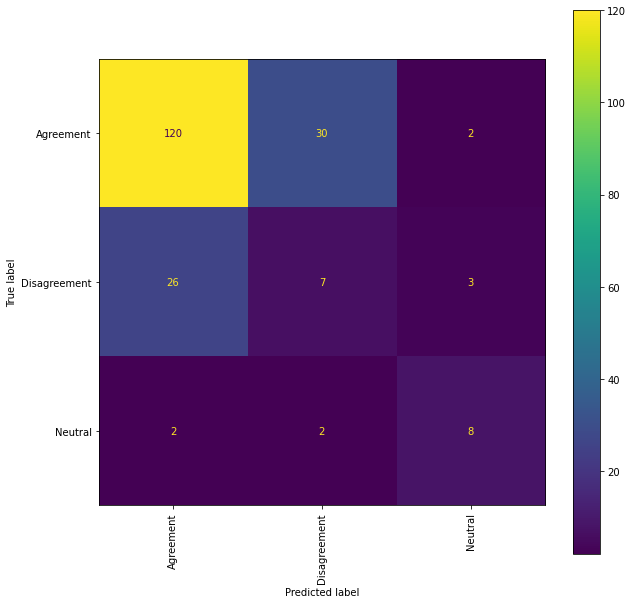

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


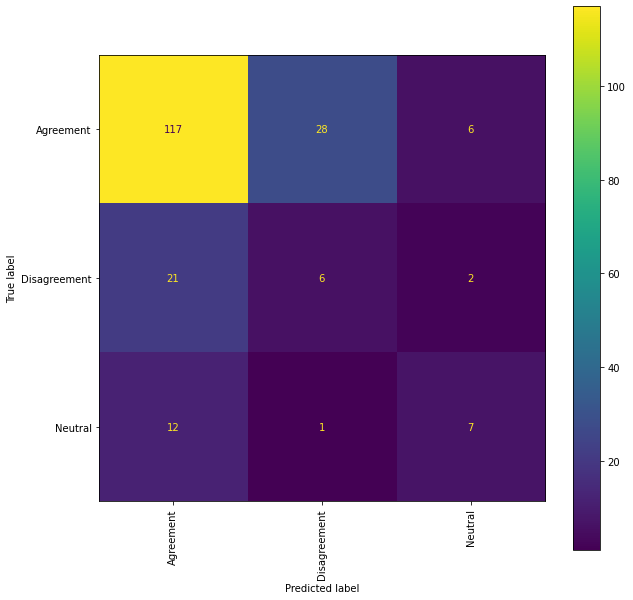

Agreement	0.548	?
Agreement	0.389	%
Agreement	0.347	s
Agreement	0.330	&
Agreement	0.277	least
Agreement	0.254	https
Agreement	0.247	get
Agreement	0.246	vaccines
Agreement	0.244	infections
Agreement	0.241	d

Disagreement	0.756	though
Disagreement	0.595	finding
Disagreement	0.572	safe
Disagreement	0.564	major
Disagreement	0.556	effective
Disagreement	0.523	find
Disagreement	0.476	nt
Disagreement	0.416	?
Disagreement	0.405	paper
Disagreement	0.378	simply

Neutral	0.907	reported
Neutral	0.741	cases
Neutral	0.634	criteria
Neutral	0.564	avoiding
Neutral	0.554	abstract
Neutral	0.482	reducing
Neutral	0.410	b
Neutral	0.409	produced
Neutral	0.407	covid19
Neutral	0.379	need



In [39]:
run_punct(trainingFile, devFile, testFile)

### using SMOTETomek

In [40]:
from imblearn.combine import SMOTEENN ,SMOTETomek

In [41]:
class Classifier_SMOTE_undersample:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        # self.trainY=trainY
        self.devY=devY
        self.testY=testY

      
        trainX = self.process(trainX, training=True)

        # oversample training set
        self.trainX, self.trainY = self.oversample_train(trainX,trainY)


        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)



    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data


    def oversample_train(self,trainX,trainY):
      sm = SMOTETomek(random_state=20)
      X_train_res, y_train_res = sm.fit_resample(trainX, trainY)

      return X_train_res, y_train_res


    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
          
        data = self.featurize(X_data)
        # print(data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        # print(X)


        # 
        return X

    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        print("D:",D)
        print("F:",F)
        
        # summarize the new class distribution
        counter = Counter(self.trainY)
        print("COUNTS:",counter)

        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
      return self.log_reg.score(self.testX, self.testY)

    def dev(self):
      return self.log_reg.score(self.devX, self.devY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [42]:
def run_punct(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    # remove stopwords
    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    # remove punct
    trainX = list(map(punct_removal, trainX))
    devX = list(map(punct_removal, devX))
    testX = list(map(punct_removal, testX))

    simple_classifier = Classifier_SMOTE_undersample(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))

    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)
    
    simple_classifier.printWeights()

D: 1326
F: 2187
COUNTS: Counter({'Agreement': 442, 'Disagreement': 442, 'Neutral': 442})
Dev accuracy for best dev model: 0.675, 95% CIs: [0.610 0.740]

Test accuracy for best dev model: 0.650, 95% CIs: [0.610 0.740]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


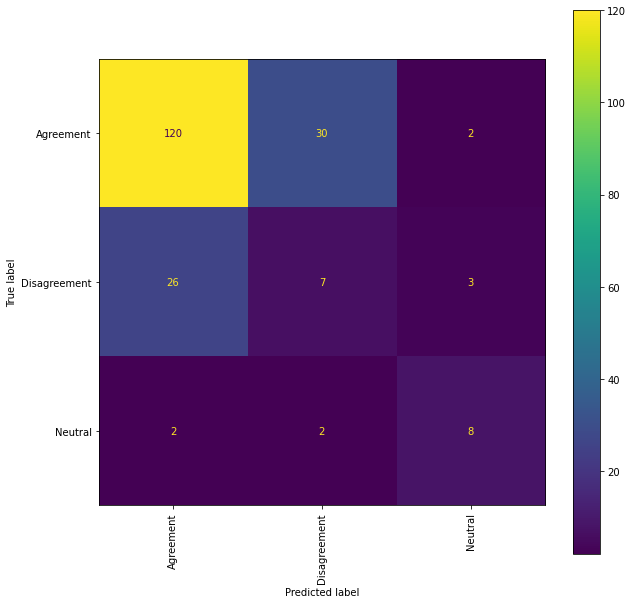

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


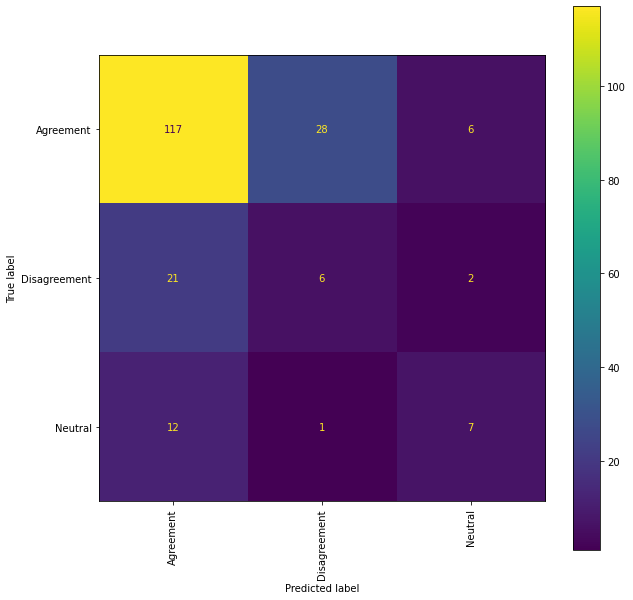

Agreement	0.548	?
Agreement	0.389	%
Agreement	0.347	s
Agreement	0.330	&
Agreement	0.277	least
Agreement	0.254	https
Agreement	0.247	get
Agreement	0.246	vaccines
Agreement	0.244	infections
Agreement	0.241	d

Disagreement	0.756	though
Disagreement	0.595	finding
Disagreement	0.572	safe
Disagreement	0.564	major
Disagreement	0.556	effective
Disagreement	0.523	find
Disagreement	0.476	nt
Disagreement	0.416	?
Disagreement	0.405	paper
Disagreement	0.378	simply

Neutral	0.907	reported
Neutral	0.741	cases
Neutral	0.634	criteria
Neutral	0.564	avoiding
Neutral	0.554	abstract
Neutral	0.482	reducing
Neutral	0.410	b
Neutral	0.409	produced
Neutral	0.407	covid19
Neutral	0.379	need



In [43]:
run_punct(trainingFile, devFile, testFile)


### another method - using SMOTE and Randomundersampler

In [44]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [45]:
class Classifier_SMOTE_undersample:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        # self.trainY=trainY
        self.devY=devY
        self.testY=testY

      
        trainX = self.process(trainX, training=True)

        # oversample training set
        self.trainX, self.trainY = self.oversample_train(trainX,trainY)


        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)



    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data


    def oversample_train(self,trainX,trainY):

      over = SMOTE()
      under = RandomUnderSampler()

      steps = [('o', over), ('u', under)]
      pipeline = Pipeline(steps=steps)
      # sm = SMOTETomek(random_state=20)
      X_train_res, y_train_res = pipeline.fit_resample(trainX, trainY)

      return X_train_res, y_train_res


    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
          
        data = self.featurize(X_data)
        # print(data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        # print(X)


        # 
        return X

    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        print("D:",D)
        print("F:",F)
        
        # summarize the new class distribution
        counter = Counter(self.trainY)
        print("COUNTS:",counter)

        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
      return self.log_reg.score(self.testX, self.testY)

    def dev(self):
      return self.log_reg.score(self.devX, self.devY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [46]:
def run_punct(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    # remove stopwords
    trainX = list(map(remove_stop_df, trainX))
    devX = list(map(remove_stop_df, devX))
    testX = list(map(remove_stop_df, testX))

    # remove punct
    trainX = list(map(punct_removal, trainX))
    devX = list(map(punct_removal, devX))
    testX = list(map(punct_removal, testX))

    simple_classifier = Classifier_SMOTE_undersample(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()

    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))

    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)
    
    simple_classifier.printWeights()

D: 1326
F: 2187
COUNTS: Counter({'Agreement': 442, 'Disagreement': 442, 'Neutral': 442})
Dev accuracy for best dev model: 0.690, 95% CIs: [0.626 0.754]

Test accuracy for best dev model: 0.620, 95% CIs: [0.626 0.754]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


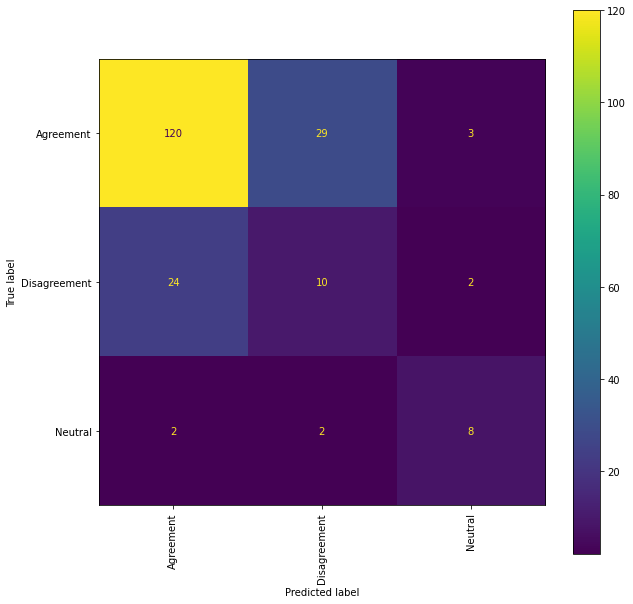

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


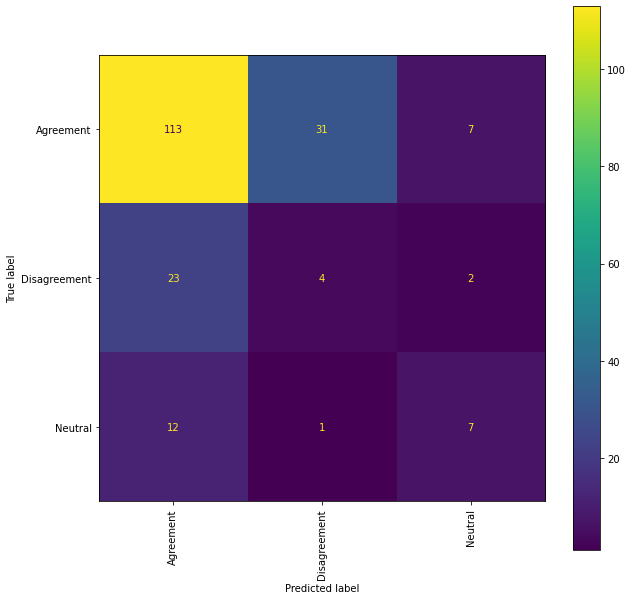

Agreement	0.553	?
Agreement	0.358	s
Agreement	0.350	%
Agreement	0.329	&
Agreement	0.285	least
Agreement	0.260	d
Agreement	0.257	https
Agreement	0.252	likely
Agreement	0.238	could
Agreement	0.236	infections

Disagreement	0.718	though
Disagreement	0.634	find
Disagreement	0.552	effective
Disagreement	0.545	safe
Disagreement	0.538	finding
Disagreement	0.504	major
Disagreement	0.497	nt
Disagreement	0.432	paper
Disagreement	0.414	?
Disagreement	0.405	essentially

Neutral	0.916	reported
Neutral	0.747	cases
Neutral	0.631	criteria
Neutral	0.568	avoiding
Neutral	0.549	abstract
Neutral	0.488	reducing
Neutral	0.425	need
Neutral	0.422	produced
Neutral	0.414	covid19
Neutral	0.402	different



In [47]:
run_punct(trainingFile, devFile, testFile)


### ngram BOW

In [15]:
from sklearn.feature_extraction.text import CountVectorizer


In [70]:
test_text_2=['my name ius GK','fdhbsjhb skdbskjbdsd d','dfdf efdf e']

In [104]:

# Construct the tokenizer with English stop words
bigram = CountVectorizer(ngram_range=(1, 2))
# fit the model to the passage
# test_text = "my name is mudit"
# bigram.fit(test_text_2)
bigram.fit_transform(test_text_2)

# bigram.get_feature_names()

<3x13 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [76]:
bigram.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['dfdf',
 'dfdf efdf',
 'efdf',
 'fdhbsjhb',
 'fdhbsjhb skdbskjbdsd',
 'gk',
 'ius',
 'ius gk',
 'my',
 'my name',
 'name',
 'name ius',
 'skdbskjbdsd']

In [79]:
bigram.transform(test_text_2)

<3x13 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [103]:
X

<3x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Dictionary Of Keys format>

In [78]:
print("Sentence Encoding: \n")
# Print the encoding of each line
for (text, encoding) in zip(test_text_2, bigram.transform(test_text_2)):
    print(text)
    print(encoding)
    print("------------------")

Sentence Encoding: 

my name ius GK
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
------------------
fdhbsjhb skdbskjbdsd d
  (0, 3)	1
  (0, 4)	1
  (0, 12)	1
------------------
dfdf efdf e
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
------------------


In [80]:
def binary_bow_featurize(text):
  feats = {}
  words = nltk.word_tokenize(text)

  for word in words:
      word=word.lower()
      feats[word]=1
          
  return feats


def featurize(data):
    featurized_data = []
    for text in data:
        feats = binary_bow_featurize(text)
        featurized_data.append(feats)
    return featurized_data

In [81]:
test_text_2=['my name ius GK','fdhbsjhb skdbskjbdsd d','dfdf efdf e']
featurize(test_text_2)

[{'gk': 1, 'ius': 1, 'my': 1, 'name': 1},
 {'d': 1, 'fdhbsjhb': 1, 'skdbskjbdsd': 1},
 {'dfdf': 1, 'e': 1, 'efdf': 1}]

In [99]:
data = featurize(test_text_2)
feature_doc_count = Counter()
for feats in data:
    for feat in feats:
        feature_doc_count[feat]+= 1

fid = 0
feature_vocab = {}
for feat in feature_doc_count:
  print(feat)
  if feature_doc_count[feat] >= 1:
      feature_vocab[feat] = fid
      fid += 1


F = len(feature_vocab)
D = len(data)
X = sparse.dok_matrix((D, F))
for idx, feats in enumerate(data):
    for feat in feats:
        if feat in feature_vocab:
            X[idx, feature_vocab[feat]] = feats[feat]

my
name
ius
gk
fdhbsjhb
skdbskjbdsd
d
dfdf
efdf
e


In [102]:
X

<3x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Dictionary Of Keys format>

In [32]:
class Classifier_ngram:

    def __init__(self, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        # self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX)
        print(self.trainX.shape)
        self.devX = self.process(devX)
        self.testX = self.process(testX)



    # Featurize entire dataset
    # def featurize(self, data):
    #     featurized_data = []
    #     for text in data:
    #         feats = self.feature_method(text)
    #         featurized_data.append(feats)
    #     return featurized_data


    # def binary_bow_featurize(text):
    #   feats = {}
    #   words = nltk.word_tokenize(text)

    #   for word in words:
    #       word=word.lower()
    #       feats[word]=1
              
    #   return feats
    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):


        bigram = CountVectorizer(ngram_range=(1, 2))
        X = bigram.fit_transform(X_data)

        print("X:",X.shape)
          
        # data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X

    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        print(D)
        print(F)
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
      return self.log_reg.score(self.testX, self.testY)

    def dev(self):
      return self.log_reg.score(self.devX, self.devY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [33]:
def run_ngram(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)

    # remove stopwords
    # trainX = list(map(remove_stop_df, trainX))
    # devX = list(map(remove_stop_df, devX))
    # testX = list(map(remove_stop_df, testX))

    # remove punct
    # trainX = list(map(punct_removal, trainX))
    # devX = list(map(punct_removal, devX))
    # testX = list(map(punct_removal, testX))

    simple_classifier = Classifier_ngram(trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy_test=simple_classifier.test()
    accuracy_dev=simple_classifier.dev()
    
    lower, upper=confidence_intervals(accuracy_dev, len(devY), .95)
    print("Dev accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_dev, lower, upper))
    lower, upper=confidence_intervals(accuracy_dev, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy_test, lower, upper))

    print_confusion(simple_classifier)
    print_confusion_test(simple_classifier)
    
    simple_classifier.printWeights()

In [34]:
run_ngram(trainingFile, devFile, testFile)

X: (600, 28594)
(600, 28594)
X: (200, 11524)
X: (200, 14708)
600
28594


ValueError: ignored